### 01) Importy i ścieżki

In [23]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import time
from google.cloud import vision
import matplotlib.pyplot as plt
import os
from google.cloud import vision

# katalog wejściowy
DIR_DATA = Path("data/test_scenes")
DIR_DATA

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/olga/MetaLogic/secrets/vision-key.json"
print("Ustawiono GOOGLE_APPLICATION_CREDENTIALS")

vision_client = vision.ImageAnnotatorClient()
print("Vision OK")

Ustawiono GOOGLE_APPLICATION_CREDENTIALS
Vision OK


### 2) Ładowanie obrazu

In [24]:
def load_image(path: Path) -> Image.Image:
    return Image.open(path).convert("RGB")

### 3) Tiling (dzielimy obraz na równą siatkę)

In [25]:
def generate_tiles(img: Image.Image, n_cols=3, n_rows=3):
    """
    Zwraca listę (tile, bbox) dla każdego kafla:
    bbox = (x1, y1, x2, y2) w oryginalnym obrazie.
    """
    W, H = img.size
    tiles = []

    w = W // n_cols
    h = H // n_rows

    for r in range(n_rows):
        for c in range(n_cols):
            x1 = c * w
            y1 = r * h
            x2 = (c + 1) * w if c < n_cols - 1 else W
            y2 = (r + 1) * h if r < n_rows - 1 else H

            tile = img.crop((x1, y1, x2, y2))
            tiles.append((tile, (x1, y1, x2, y2)))

    return tiles

### 4) Proste podbicie OCR (bez przesady)

In [26]:
def enhance_for_ocr(img: Image.Image):
    # minimalne wzmocnienie — nie zmienia wyglądu oryginału
    import cv2
    arr = np.array(img)
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    return Image.fromarray(norm)

### 5) OCR jednego cropa (linie + bbox)

In [27]:
def ocr_crop_with_boxes(img_crop: Image.Image, lang=("pl",)):
    import io
    buf = io.BytesIO()
    img_crop.save(buf, format="PNG")
    image = vision.Image(content=buf.getvalue())

    response = vision_client.document_text_detection(
        image=image,
        image_context=vision.ImageContext(language_hints=list(lang)),
    )

    out = []
    if not response.full_text_annotation:
        return out

    annotation = response.full_text_annotation

    for page in annotation.pages:
        for block in page.blocks:
            for para in block.paragraphs:

                line_words = []
                line_bbox = None

                for word in para.words:
                    w_text = "".join([s.text for s in word.symbols])
                    line_words.append(w_text)

                    v = word.bounding_box.vertices
                    wx1, wy1 = v[0].x, v[0].y
                    wx2, wy2 = v[2].x, v[2].y

                    if line_bbox is None:
                        line_bbox = [wx1, wy1, wx2, wy2]
                    else:
                        line_bbox[0] = min(line_bbox[0], wx1)
                        line_bbox[1] = min(line_bbox[1], wy1)
                        line_bbox[2] = max(line_bbox[2], wx2)
                        line_bbox[3] = max(line_bbox[3], wy2)

                if line_words:
                    out.append({
                        "text": " ".join(line_words).strip(),
                        "bbox": tuple(int(v) for v in line_bbox),
                    })

    return out

### 6) OCR całego obrazu czystym tilingiem

In [28]:
def ocr_image_tiled(path: Path, n_cols=3, n_rows=3):
    img = load_image(path)
    tiles = generate_tiles(img, n_cols=n_cols, n_rows=n_rows)

    records = []

    for tile, bbox in tiles:
        tile_prep = enhance_for_ocr(tile)
        lines = ocr_crop_with_boxes(tile_prep)

        for ln in lines:
            records.append({
                "file_path": str(path),
                "tile_bbox": bbox,
                "ocr_line_bbox": ln["bbox"],
                "text": ln["text"],
            })

    return records


### 7) OCR całego folderu

In [29]:
# %%
MAX_IMAGES = 20

# tylko prawdziwe obrazy
VALID_EXT = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}

all_imgs = [
    p for p in sorted(DIR_DATA.glob("*"))
    if p.suffix.lower() in VALID_EXT
][:MAX_IMAGES]

print("Liczba obrazów:", len(all_imgs))

all_records = []
t0 = time.time()

for i, p in enumerate(all_imgs, start=1):
    print(f"[{i}/{len(all_imgs)}] OCR:", p.name)
    recs = ocr_image_tiled(p, n_cols=3, n_rows=3)
    all_records.extend(recs)

print("\nCzas:", round(time.time() - t0, 1), "s")
print("Liczba rekordów OCR:", len(all_records))

df_ocr = pd.DataFrame(all_records)
df_ocr.head()

Liczba obrazów: 20
[1/20] OCR: JMi_0014.jpg
[2/20] OCR: JMi_0127.tif
[3/20] OCR: JMi_0128.tif
[4/20] OCR: JMi_0129.tif
[5/20] OCR: JMi_0131.tif
[6/20] OCR: JMi_0175.jpg
[7/20] OCR: JMi_0177.jpg
[8/20] OCR: JMi_0192.tif
[9/20] OCR: JMi_0339.tif
[10/20] OCR: JMi_0342.tif
[11/20] OCR: JMi_0344.tif
[12/20] OCR: JMi_0348.tif
[13/20] OCR: JMi_0349.tif
[14/20] OCR: JMi_0350.tif
[15/20] OCR: JMi_0356.tif
[16/20] OCR: JMi_0359.jpg
[17/20] OCR: JMi_0360.tif
[18/20] OCR: JMi_0363.tif
[19/20] OCR: JMi_0365.jpg
[20/20] OCR: JMi_0366.jpg

Czas: 69.2 s
Liczba rekordów OCR: 142


,file_path,tile_bbox,ocr_line_bbox,text
0,data/test_scenes/JMi_0128.tif,"(1338, 0, 2676, 893)","(1278, 611, 1201, 646)",7
1,data/test_scenes/JMi_0128.tif,"(2676, 1786, 4016, 2680)","(674, 144, 640, 117)",10
2,data/test_scenes/JMi_0131.tif,"(1473, 977, 2946, 1954)","(891, 917, 818, 976)",E
3,data/test_scenes/JMi_0192.tif,"(2984, 0, 4478, 969)","(1115, 883, 1158, 954)",t
4,data/test_scenes/JMi_0192.tif,"(2984, 969, 4478, 1938)","(0, 479, 48, 502)",F


### 8) Funkcje końcowe: 
1) Wizualizacja OCR na obrazie (overlay bounding boxów)
2) Siatka thumbnails z OCR (grid)
3) Merging akapitów (łączenie linii)

In [37]:
# %%
"""
Overlay OCR + grid thumbnails na podstawie df_ocr (bez YOLO).
"""

import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageDraw
from pathlib import Path


def draw_ocr_overlay(path: Path, df_ocr: pd.DataFrame):
    """
    Rysuje bounding boxy OCR na obrazie.

    df_ocr: kolumny
      - file_path      – ścieżka pliku
      - tile_bbox      – (tx1, ty1, tx2, ty2) – bbox kafelka w oryginalnym obrazie
      - ocr_line_bbox  – (bx1, by1, bx2, by2) – bbox linii w układzie kafelka
      - text           – tekst linii
    """
    img = load_image(path).copy()
    draw = ImageDraw.Draw(img)

    sub = df_ocr[df_ocr["file_path"] == str(path)]
    if sub.empty:
        # brak OCR dla tego obrazu – zwracamy oryginał
        return img

    for _, row in sub.iterrows():
        tx1, ty1, tx2, ty2 = row["tile_bbox"]
        bx1, by1, bx2, by2 = row["ocr_line_bbox"]

        # współrzędne linii w całym obrazie
        x1 = tx1 + bx1
        y1 = ty1 + by1
        x2 = tx1 + bx2
        y2 = ty1 + by2

        # porządkowanie, żeby x1<=x2, y1<=y2
        x1, x2 = int(min(x1, x2)), int(max(x1, x2))
        y1, y2 = int(min(y1, y2)), int(max(y1, y2))

        # odrzucamy dziwne boxy
        if x2 <= x1 or y2 <= y1:
            continue

        draw.rectangle((x1, y1, x2, y2), outline="red", width=2)
        txt = str(row["text"])[:40]
        draw.text((x1 + 3, y1 + 3), txt, fill="red")

    return img


def show_ocr_grid(df_ocr: pd.DataFrame, all_image_paths, max_images=20, n_cols=4):
    """
    Pokazuje tylko te obrazy, dla których są rekordy OCR.
    Bez pustych wykresów.
    """
    # unikamy pustych osi – wybieramy tylko pliki obecne w df_ocr
    files_with_ocr = set(df_ocr["file_path"].unique())
    image_paths = [p for p in all_image_paths if str(p) in files_with_ocr]

    image_paths = image_paths[:max_images]
    n = len(image_paths)

    if n == 0:
        print("Brak obrazów z OCR.")
        return

    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, path in zip(axes, image_paths):
        ax.axis("off")
        img_overlay = draw_ocr_overlay(path, df_ocr)
        ax.imshow(img_overlay)
        ax.set_title(path.name, fontsize=9)

    # ukryj nadmiarowe osie
    for ax in axes[len(image_paths):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

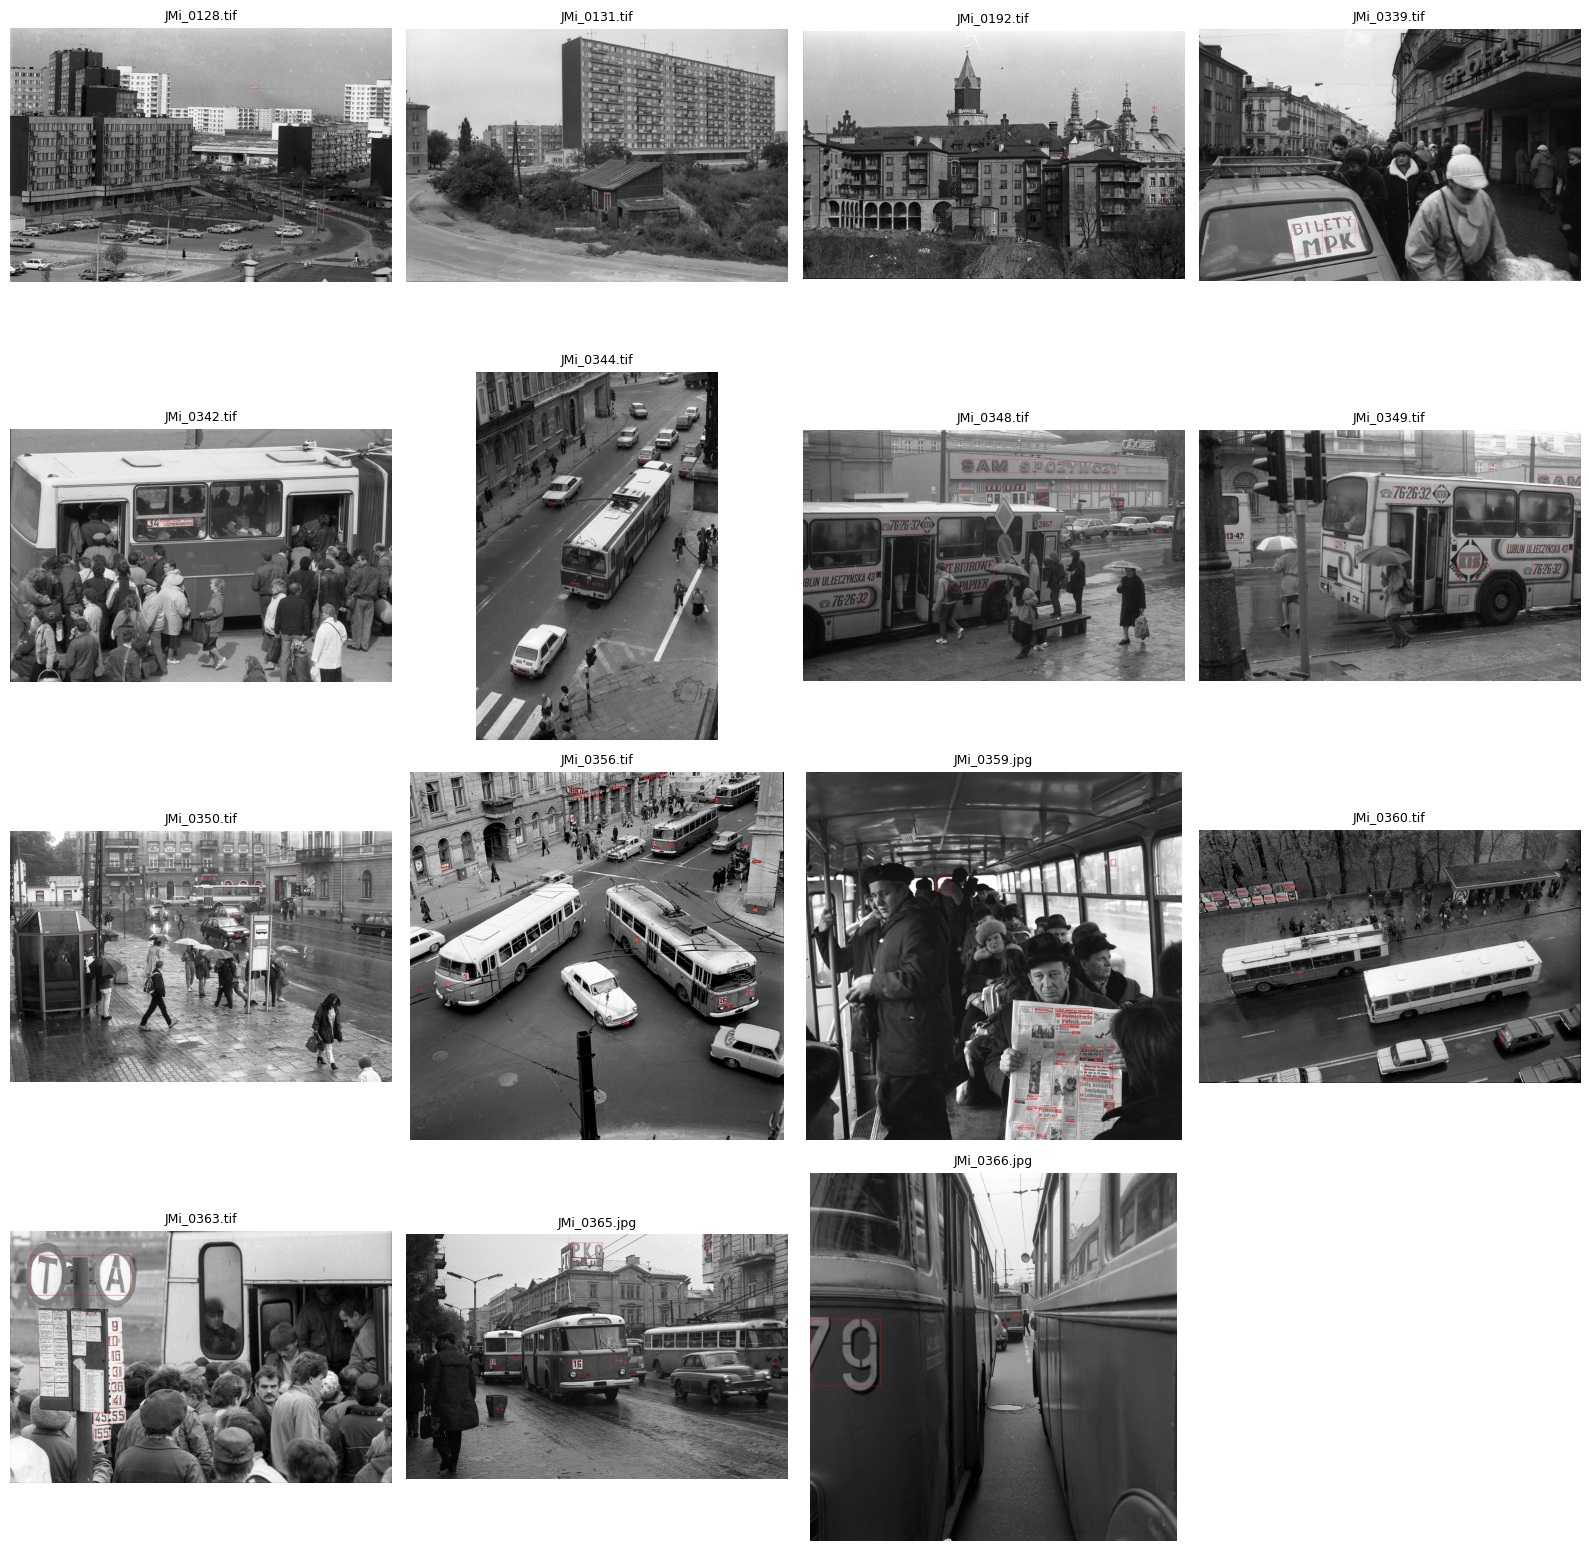

In [41]:
# wszystkie obrazy, dla których Vision coś znalazł
show_ocr_grid(df_ocr, all_imgs, max_images=50, n_cols=4)

In [42]:
OUT_CSV = Path("data/ocr_results.csv")
df_ocr.to_csv(OUT_CSV, index=False)
OUT_CSV

PosixPath('data/ocr_results.csv')

In [45]:
# %%
"""
Agregacja wyników OCR per obraz:
- wykrywanie, czy zdjęcie ma tekst (has_text)
- liczba linii i długość tekstu
"""

def summarize_ocr(df_ocr: pd.DataFrame) -> pd.DataFrame:
    if df_ocr.empty:
        print("df_ocr jest pusty – brak wyników OCR.")
        return pd.DataFrame()

    # grupowanie po pliku
    grp = df_ocr.groupby("file_path")["text"]

    df_summary = pd.DataFrame({
        "n_lines": grp.apply(lambda s: sum(bool(str(t).strip()) for t in s)),
        "total_chars": grp.apply(lambda s: sum(len(str(t)) for t in s)),
        "sample_text": grp.apply(
            lambda s: " | ".join(str(t).strip() for t in s if str(t).strip())[:300]
        ),
    })

    df_summary["has_text"] = df_summary["n_lines"] > 0

    return df_summary.reset_index()

df_ocr_summary = summarize_ocr(df_ocr)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

df_ocr_summary

,file_path,n_lines,total_chars,sample_text,has_text
0,data/test_scenes/JMi_0128.tif,2,3,7 | 10,True
1,data/test_scenes/JMi_0131.tif,1,1,E,True
2,data/test_scenes/JMi_0192.tif,3,3,t | F | I,True
3,data/test_scenes/JMi_0339.tif,3,18,upomink | BIL M | ETY PK,True
4,data/test_scenes/JMi_0342.tif,4,49,34 | LECZYNSKA ELENINA DK CL PKS | DS SZYMANOWSKIEGO | CIE,True
5,data/test_scenes/JMi_0344.tif,6,42,LLS 0504 | LD 93 | LLC 946 | LUC 876N | 3-0753 | LLD 7160,True
6,data/test_scenes/JMi_0348.tif,16,155,SAM SPO | KOZIOLEK | GOSH DOMOWE | GOSE DOMOWE | ROSIE DELIKATESUNE | ZYWCZY | KOZIO ZIOŁEK | DO WELIN | ZACIN STRAIZI | BLIN ULŁECZYŃSKA 43 | 76-26-32 | RT BIUROWE PAPIER | 2067 | LL # 4253 | LB | 70,True
7,data/test_scenes/JMi_0349.tif,10,63,76-26-32 | H | SAM | 13-42 | 2067 | KIS | PORT | IMPORT | LUBLIN ULKECZYŃSKA 43 | 76-26-32,True
8,data/test_scenes/JMi_0350.tif,11,54,PIZZA | ADWOKACRIE | SONY | SONY | SONY | ANTO | Kc | TAXI | A | LBB 9561 | LBD 5236,True
9,data/test_scenes/JMi_0356.tif,23,93,172 | LECZNY | 7 | ogrodowy | mleczny | art spozy | 24 | 74906 | Cze | 15 | 55 | 549 | 2's | of Lipows | I | 22 | 5 | 548 | 26 | LL - 9265 | 546 | MPO | LLS193,True


### Eksport do CSV

In [ ]:
# %%
OUT_SUMMARY = Path("data/ocr_results_per_image.csv")
df_ocr_summary.to_csv(OUT_SUMMARY, index=False)
OUT_SUMMARY